In [31]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import torchvision 
import torchvision.transforms as transforms
from PIL import Image
import os

from customDataset import CustomDataset
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import cv2
from sklearn.metrics import mean_squared_error


from neuralNet1 import NeuralNet
from VGG import VGGLoss

In [2]:
### Check if GPU is available

if torch.cuda.is_available():
    device = torch.device("cuda")
    print("Using GPU")
else:
    device = torch.device("cpu")
    print("Using CPU")

# Check for GPU availability and set device
if torch.cuda.is_available():
    device_count = torch.cuda.device_count()
    device = torch.device("cuda")
    current_device_idx = torch.cuda.current_device()
else:
    device_count = 0
    device = torch.device("cpu")
    current_device_idx = None

# Print device information
print(f"Number of available GPUs: {device_count}")
print(f"Current device index: {current_device_idx}")
print(f"Current device name: {torch.cuda.get_device_name(current_device_idx)}")

Using GPU
Number of available GPUs: 1
Current device index: 0
Current device name: NVIDIA GeForce RTX 4080


In [6]:
# Dataset creation
# hyperparameters
batch_size = 8
train_X = "data/LR_train"
train_y = "data/HR_train"
val_X = "data/LR_val"
val_y = "data/HR_val"
test_X = "data/LR_test"
test_y = "data/HR_test"


# optimizer = optim.Adam(model.parameters(), lr=1e-3)

# Define a transformation operation to normalize the images
transform = transforms.Compose([
    transforms.ToTensor()
    # transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # normalize to [-1, 1]
])


train_dataset = CustomDataset(train_X, train_y, transform=transforms.ToTensor())
val_dataset = CustomDataset(val_X, val_y, transform=transforms.ToTensor())
test_dataset = CustomDataset(test_X, test_y, transform=transforms.ToTensor())

print("dataset size: ", len(train_dataset))

#### Create the dataloaders
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

dataset size:  15000


In [7]:
#### Create the model
model = NeuralNet()

# create optimizer
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# move them to device (GPU/CPU)
model.to(device)

# loss function
loss_fn1 = VGGLoss(device)
loss_fn2 = nn.MSELoss()

epochs = 100

In [8]:
#### Training loop
for epoch in range(epochs):
    print(f"------------------\n Epoch: {epoch}")
    model.train()
    epoch_loss = 0
    batch_loss = 0
    for i, (X, y) in enumerate(train_dataloader):
        if i % 100 == 0:
            print(" Batch:", i, " Loss:", batch_loss/100)
            batch_loss = 0
        
        # retrieve data and move tensors to device
        inputs = X.to(device)
        labels = y.to(device)
        
        # calculate loss
        outputs = model(inputs)
        # loss = loss_fn1(outputs, labels)
        loss = loss_fn2(outputs, labels)
        epoch_loss += loss.item()
        batch_loss += loss.item()
        
        # zero gradient and backpropagate
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # change learning rate
        if epoch/epochs > 0.5:
            optimizer = optim.Adam(model.parameters(), lr=1e-4)
            
        
    # Print epoch information 
    print(f"Epoch {epoch+1}/{epochs}: Loss: {epoch_loss:.4f}")
    

------------------
 Epoch: 0
 Batch: 0  Loss: 0.0
 Batch: 100  Loss: 0.026173063945025207
 Batch: 200  Loss: 0.009543604692444205
 Batch: 300  Loss: 0.007857048709411174
 Batch: 400  Loss: 0.008292183168232442
 Batch: 500  Loss: 0.007614618651568889
 Batch: 600  Loss: 0.006857236984651536
 Batch: 700  Loss: 0.006539124757982791
 Batch: 800  Loss: 0.006502085677348077
 Batch: 900  Loss: 0.006287727544549853
 Batch: 1000  Loss: 0.005897676385939121
 Batch: 1100  Loss: 0.0055828055087476965
 Batch: 1200  Loss: 0.005469888166990131
 Batch: 1300  Loss: 0.005050210996996611
 Batch: 1400  Loss: 0.005006142249330878
 Batch: 1500  Loss: 0.0055957697331905365
 Batch: 1600  Loss: 0.004934904633555562
 Batch: 1700  Loss: 0.004720777205657214
 Batch: 1800  Loss: 0.004535085705574602
Epoch 1/100: Loss: 13.5714
------------------
 Epoch: 1
 Batch: 0  Loss: 0.0
 Batch: 100  Loss: 0.0047338994429446755
 Batch: 200  Loss: 0.004888598639518023
 Batch: 300  Loss: 0.005048107538605109
 Batch: 400  Loss: 0.

KeyboardInterrupt: 

In [15]:
# Preprocess the input image
image = Image.open("data\LR_test\downscaled_ci_flickr_wild_003049.jpg")
image.show()
input_image = transform(image)

real_image = Image.open("data\\HR_test\\flickr_wild_003049.jpg")
real_image.show()

# # Load the trained model
# model = DeepImagePrior(input_shape)
# model.load_state_dict(torch.load(PATH_TO_SAVED_WEIGHTS))

# Set the model to evaluation mode
model.eval()

# Perform the inference
with torch.no_grad():
    input_image = input_image.to(device)  # Move the input image to the device
    input_image = input_image.unsqueeze(0)  # Add a batch dimension
    output = model(input_image)

# Convert the output to a PIL image
output = output.squeeze(0)
output_im = transforms.ToPILImage()(output)
output_im.show()


In [12]:
##############################################
### SAVE MODEL, LOAD MODEL, WORKS ANYWHERE ###
##############################################

model_name = "model.pt"

# Save the model
torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss
            }, 'models/checkpoint.pth')

# Load the model
new_model = NeuralNet()
checkpoint = torch.load('models/checkpoint.pth')
new_model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']
loss = checkpoint['loss']

print(loss)

tensor(0.0026, device='cuda:0', requires_grad=True)


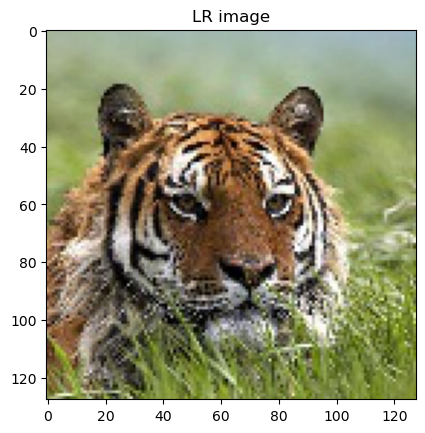

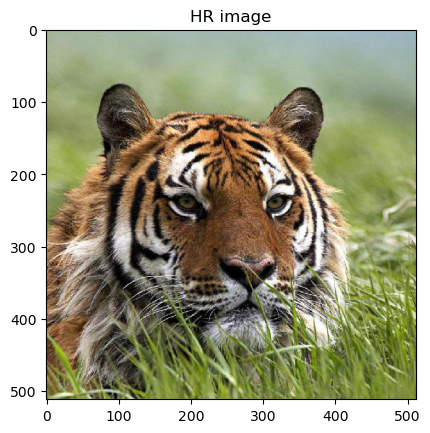

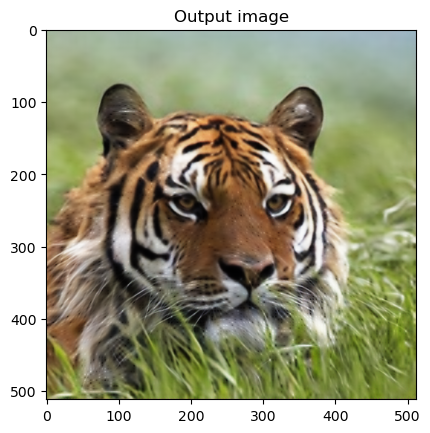

MSE: 17951.635


In [36]:
lr_image = "data/LR_test/downscaled_ci_flickr_wild_003049.jpg"
hr_image = "data/HR_test/flickr_wild_003049.jpg"

img = plt.imread(lr_image)
plt.title("LR image")
plt.imshow(img)
plt.show()

img = plt.imread(hr_image)
plt.title("HR image")
plt.imshow(img)
plt.show()

# Set the model to evaluation mode
model.eval()

image = Image.open(lr_image)
input_image = transform(image)

# Perform the inference
with torch.no_grad():
    input_image = input_image.to(device)  # Move the input image to the device
    input_image = input_image.unsqueeze(0)  # Add a batch dimension
    output = model(input_image)

# Convert to numpy array
numpy_image = output.squeeze(0).cpu().detach().numpy()

# Change the order of the dimensions from (C, H, W) to (H, W, C)
numpy_image = np.transpose(numpy_image, (1, 2, 0))

# Display the image
plt.imshow(numpy_image)
plt.title("Output image")
plt.show()

# find mse between original and reconstructed image
mse = np.mean((numpy_image - img)**2)
print("MSE:", mse)

# def count_parameters(model):
#     return sum(p.numel() for p in model.parameters() if p.requires_grad)
# count_parameters(model)

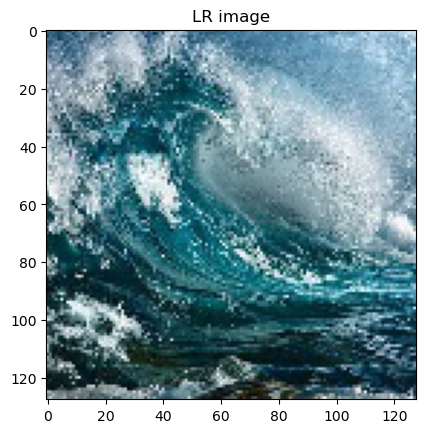

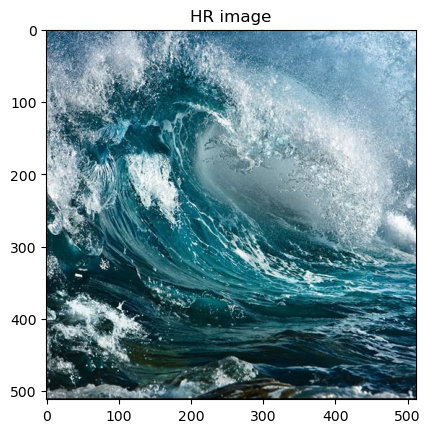

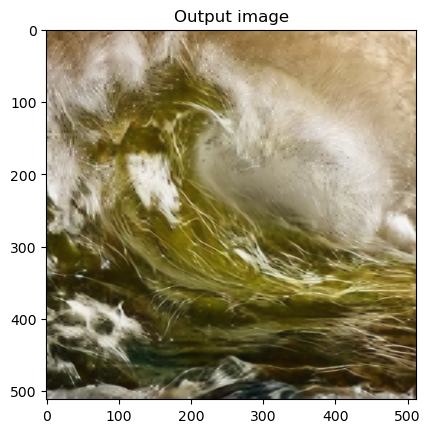

In [39]:
img_path = "waves.jpg"
downscaled_image = "downscaled_ci_waves.jpg"
image = Image.open(downscaled_image)

img = plt.imread(downscaled_image)
plt.title("LR image")
plt.imshow(img)
plt.show()

img = plt.imread(img_path)
plt.title("HR image")
plt.imshow(img)
plt.show()


# Set the model to evaluation mode
model.eval()

input_image = transform(image)

# Perform the inference
with torch.no_grad():
    input_image = input_image.to(device)  # Move the input image to the device
    input_image = input_image.unsqueeze(0)  # Add a batch dimension
    output = model(input_image)
    
# Convert to numpy array
numpy_image = output.squeeze(0).cpu().detach().numpy()

# Change the order of the dimensions from (C, H, W) to (H, W, C)
numpy_image = np.transpose(numpy_image, (1, 2, 0))

# Display the image
plt.imshow(numpy_image)
plt.title("Output image")
plt.show()